In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
from datasets import Dataset
from datasets import load_dataset

load_dotenv(override=True)

/home/jealk/mambaforge/envs/llama/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Get documents from HF

In [3]:
# Load from hub
ds_vejledninger = load_dataset(
    "jealk/dk_retrieval_benchmark",
    "retsinformation",
    split="train",
    #download_mode="force_redownload",
)

In [4]:
# Create pandas dataframe from the dataset using the huggingface datasets library
df_vejledninger = ds_vejledninger.to_pandas()
df_vejledninger.head()

,url,title,html_content,text_content
0,https://www.retsinformation.dk/eli/retsinfo/20...,Vejledning om regulering af satser fra 1. janu...,"<div class=""document-content"" id=""restylingRoo...",Vejledning om regulering af satser fra 1. janu...
1,https://www.retsinformation.dk/eli/retsinfo/20...,Vejledning om satser i 2024 for betaling af ud...,"<div class=""document-content"" id=""restylingRoo...",Vejledning om satser i 2024 for betaling af ud...
2,https://www.retsinformation.dk/eli/retsinfo/20...,Vejledning om obligatorisk selvbooking af jobs...,"<div class=""document-content"" id=""restylingRoo...",Vejledning om obligatorisk selvbooking af jobs...
3,https://www.retsinformation.dk/eli/retsinfo/20...,Vejledning til bekendtgørelse om tilskud til s...,"<div class=""document-content"" id=""restylingRoo...",Vejledning til bekendtgørelse om tilskud til s...
4,https://www.retsinformation.dk/eli/retsinfo/20...,Vejledning om fleksløntilskud m.v.,"<div class=""document-content"" id=""restylingRoo...",Vejledning om fleksløntilskud m.v.\n1.Indledni...


## Function overview

- Step 0: Chunking text
    - Include or not?
- Step 1: Filter chunks
    - W. Textdescriptives
    - W. LLM call, egnet til spørgsmål?
- Step 2: Generate questions:
    - Using LLamaIndex
- Step 3: Filter generated questions
    - (Text descriptives for long texts)
    - LLM call: Is the answer found in chunk?
    - LLM call: Is the answer clear and in a natural language?
- Step 4: Update chunk-question table
    - Embed chunks, embed questions (Local Vector DB)
    - Use vector search to identify top 10 matches
    - (Optional, Rerank)
    - Filtering: Flag query/chunks where intended match is not in Top @10
    - If question/chunk not @1
        - Use LLM to check any question/chunk scored > than "real" match
        - Update Match Matrix if OK
    - If Delta simililarity score from 'real match' to other top @10 is < threshold:
        - Use LLM to check question/chunk
        - Update Match Matrix if OK
- Step 5: Convert to BEIR format

# Step 0

In [5]:
from typing import List, Dict, Any
from llama_index.core import Document


def create_documents(text: List[str], metadata: List[Dict[str, Any]]) -> List[Document]:
    """Create a list of llama_index documents from a list of strings and a list of dictionaries

    Args:
    text: A list of strings containing the text of the documents, eg. ["Vejledning om ...", "..."]
    metadata: A list of dictionaries containing one or multiple metadata, eg. [{"title": "Example 1", "source": "website_url"}, {...}]

    Returns:
    A list of llama_index documents
    """
    documents = [
        Document(text=content, metadata=meta) for content, meta in zip(text, metadata)
    ]
    return documents

In [6]:
llama_documents = create_documents(df_vejledninger["text_content"], df_vejledninger[["title", "url"]].to_dict(orient="records"))

In [7]:
from llama_index.core.node_parser import SentenceSplitter
from transformers import AutoTokenizer
from llama_index.core.schema import TextNode


def document_splitter(
    documents: List[Document],
    chunk_size: int = 512,
    tokenizer=AutoTokenizer.from_pretrained("intfloat/e5-base-v2"),
) -> List[TextNode]:
    """Split a list of llama_index documents into nodes

    Args:
    documents: A list of llama_index documents
    chunk_size: An integer defining the maximum number of tokens in each node
    tokenizer: A tokenizer from the Hugging Face transformers library

    Returns:
    A list of nodes, consisting of text, metadata, embeddings and node-relations
    """
    node_parser = SentenceSplitter(
        chunk_size=chunk_size,
        chunk_overlap=0,
        secondary_chunking_regex=str(["\n"]),
        paragraph_separator=str(["\n\n"]),
        tokenizer=tokenizer.tokenize,
    )
    nodes = node_parser.get_nodes_from_documents(documents, show_progress=True)
    return nodes


nodes_vejledninger = document_splitter(llama_documents)

Parsing nodes: 100%|██████████| 433/433 [01:31<00:00,  4.71it/s]


# Step 1

**Filtering using text descriptives**

In [8]:
nodes_vejledninger_sample = nodes_vejledninger[:300]

In [9]:
import textdescriptives as td
import spacy

def filter_nodes_by_td(nodes: List[TextNode], filter_type: bool=True) -> List[TextNode]:
    """Filter nodes by the textdescriptives quality check

    Args:
    nodes: A list of llama_index nodes
    fiter_type: A boolean defining whether to filter by nodes that passed (True) or failed (False) the textdescriptives quality check

    Returns:
    A list of llama_index nodes that passed the textdescriptives quality check
    """
    nlp = spacy.blank("da")
    nlp.add_pipe("sentencizer")
    quality_pipe = nlp.add_pipe("textdescriptives/quality")
    docs = list(nlp.pipe([node.text for node in nodes]))
    filtered_nodes = [node for node, doc in zip(nodes, docs) if doc._.passed_quality_check==filter_type]
    
    return filtered_nodes


In [10]:
#filter
nodes_passed_td = filter_nodes_by_td(nodes_vejledninger_sample)

**Filtering using LLM call**

In [ ]:
#Gample prompts

#system prompt
"""Din opgave er at evaluere hvorvidt et uddrag af en tekst, er egnet til at stille et generelt spørgsmål til.
    Du skal vurdere om uddraget indeholder klare og faktuelle informationer, hvorfra der kan formuleres et præcist, naturligt og kort spørgsmål der kan besvares ud fra uddraget.
    Du skal give scoren 1 til teksten, hvis der kan opstilles et naturligt formuleret spørgsmål til uddraget, som eksempelvis kunne bruges i sammenhæng med en eksamen eller test.
    Du skal give scoren 0 til teksten, hvis uddraget ikke indeholder generel faktuel information, hvis teksten er for usammenhængende eller detaljeret til at kunne formulere et generelt spørgsmål.
    Returner en json med key: llm_score og value i form af en int: "0" eller "1".
"""

#Few shot user prompt
""" Du er en erfaren sagsbehandler, nedenfor er eksempler på tekstuddrag og deres tilhørende score.

    ============================
    Start på eksempel, som skal have scoren 1:

    "Vejledning om regulering af satser fra 1. januar 2024 efter lov om arbejdsskadesikring, lov om sikring mod følger af arbejdsskade, lov om arbejdsskadeforsikring og lov om forsikring mod følger af ulykkestilfælde Indledning Efter lov om arbejdsskadesikring, jf. lovbekendtgørelse nr. 1186 af 19. august 2022 med de ændringer, der følger af lov nr. 1541 af 12. december 2023, og lov om sikring mod følger af arbejdsskade, jf. lovbekendtgørelse nr. 943 af 16. oktober 2000, skal der med virkning fra 1. januar 2024 efter indstilling fra bestyrelsen for Arbejdsmarkedets Erhvervssikring ske regulering af lovens årslønsbeløb, godtgørelsesbeløb, overgangsbeløb samt løbende erstatninger. Reguleringen af satserne fastsættes af Arbejdstilsynets direktør efter bemyndigelse fra beskæftigelsesministeren. Satser efter loven reguleres med 2 procent tillagt tilpasningsprocenten for finansåret 2024 (jf. lov om en satsreguleringsprocent)."

    Fordi uddraget indeholder klare og faktuelle informationer, hvorfra der kan formuleres et præcist, naturligt og kort spørgsmål der kan besvares ud fra uddraget, eksempelvis:

    "Hvem fastsætter reguleringen af satserne for arbejdsskadesikring og andre relaterede ydelser?"

    ============================
    Start på eksempel, som skal have scoren 0:

    "årligt. 8)Uddannelsesgodtgørelsen i en forlænget periode efter § 18 b, stk. 3, 2. pkt., udgør 244.140 kr. årligt. Grundlønnen for beregning og regulering af løbende erstatning og uddannelsesgodtgørelse for arbejdsskader indtruffet den 1. juli 2024 eller senere er den efter lov om arbejdsskadesikring § 24 fastsatte årsløn multipliceret med 608.000/608.000, jf. § 24 a. Fastsættes en løbende erstatning eller en uddannelsesgodtgørelse den 1. juli 2024 eller senere, udbetales erstatningen eller godtgørelsen fra tidspunktet for dennes begyndelse med et tillæg på 0,0 pct. til den erstatning eller godtgørelse, der svarer til grundlønnen. Satser for arbejdsskader indtruffet i tiden 1. januar 2024 til 30. juni 2024 Med virkning for arbejdsskader efter lov om arbejdsskadesikring, jf. lovbekendtgørelse nr. 1186 af 19. august 2022 med de ændringer, der følger af lov nr."

    Fordi der uddraget ikke indeholder meget detaljerede informationer der er svære at forstå uden kontekst, generelt er fragmenteret og gør det vanskeligt at formulere et generelt spørgsmål.

    ==============================
    Uddrag som du skal give en score:

    {chunk_text}"

    Returner KUN tallet 0 eller 1, ingen yderligere forklaring
"""
    

In [11]:
import json
import logging
from typing import Dict, Any
#import openai client chat

from openai import OpenAI
client = OpenAI()


# Returner din vurdering som enten 0 eller 1, baseret på tekstuddragets opfyldelse af de nævnte kriterier.

def create_user_prompt(text: str) -> str:
    """Prepare the prompt for the API call."""
    
    qa_egnet_tmlp = """Du er en erfaren sagsbehandler. Nedenfor er konkrete eksempler på hvordan et tekstuddrag kan se ud, og hvordan de skal vurderes.
    ============================
    Eksempel 1 (Score: 1):
    "Vejledning om regulering af satser fra 1. januar 2024 efter lov om arbejdsskadesikring, lov om sikring mod følger af arbejdsskade, lov om arbejdsskadeforsikring og lov om forsikring mod følger af ulykkestilfælde. Efter lov om arbejdsskadesikring, jf. lovbekendtgørelse nr. 1186 af 19. august 2022 med de ændringer, der følger af lov nr. 1541 af 12. december 2023, og lov om sikring mod følger af arbejdsskade, jf. lovbekendtgørelse nr. 943 af 16. oktober 2000, skal der med virkning fra 1. januar 2024 efter indstilling fra bestyrelsen for Arbejdsmarkedets Erhvervssikring ske regulering af lovens årslønsbeløb, godtgørelsesbeløb, overgangsbeløb samt løbende erstatninger. Reguleringen af satserne fastsættes af Arbejdstilsynets direktør efter bemyndigelse fra beskæftigelsesministeren. Satser efter loven reguleres med 2 procent tillagt tilpasningsprocenten for finansåret 2024 (jf. lov om en satsreguleringsprocent)."
    Argument for Score 1: Tekstuddraget indeholder klare, faktuelle informationer og præsenterer en specifik procedure for regulering af satser, hvilket gør det muligt at formulere et direkte og relevant spørgsmål, såsom "Hvem fastsætter reguleringen af satserne for arbejdsskadesikring og andre relaterede ydelser?" Dette opfylder kriterierne for klarhed, konkret information, og kontekstuel helhed.
    
    ============================
    Eksempel 2 (Score: 0):
    "årligt. 8) Uddannelsesgodtgørelsen i en forlænget periode efter § 18 b, stk. 3, 2. pkt., udgør 244.140 kr. årligt. Grundlønnen for beregning og regulering af løbende erstatning og uddannelsesgodtgørelse for arbejdsskader indtruffet den 1. juli 2024 eller senere er den efter lov om arbejdsskadesikring § 24 fastsatte årsløn multipliceret med 608.000/608.000, jf. § 24 a. Fastsættes en løbende erstatning eller en uddannelsesgodtgørelse den 1. juli 2024 eller senere, udbetales erstatningen eller godtgørelsen fra tidspunktet for dennes begyndelse med et tillæg på 0,0 pct. til den erstatning eller godtgørelse, der svarer til grundlønnen. Satser for arbejdsskader indtruffet i tiden 1. januar 2024 til 30. juni 2024 Med virkning for arbejdsskader efter lov om arbejdsskadesikring, jf. lovbekendtgørelse nr. 1186 af 19. august 2022 med de ændringer, der følger af lov nr."
    Argument for Score 0: Dette uddrag er fragmenteret og præsenterer information på en måde, der er svær at forstå uden yderligere kontekst. Det mangler en klar struktur og introducerer flere specifikke detaljer uden at forklare deres relevans eller sammenhæng, hvilket gør det vanskeligt at formulere et generelt spørgsmål. Dette opfylder ikke kriterierne for klarhed, konkret information, eller kontekstuel helhed.

    ============================
    Din Opgave:
    Vurder det følgende tekstuddrag og angiv, om det er egnet til at stille et generelt spørgsmål til.

    Uddrag:
    {chunk_text}
    Returner din score i dette format:

    {{
        "llm_score": [indsæt enten 0 eller 1 her]
    }}
    """
    return qa_egnet_tmlp.format(chunk_text=text)


def create_system_prompt():
    sys_prompt = """Din opgave er at evaluere et givet tekstuddrag for at bestemme, om det er egnet til at danne grundlag for et generelt spørgsmål, der er relevant for eksempelvis en eksamen eller en test. 
    For at vurdere dette, skal du fokusere på følgende tre nøglekriterier:

    1. Klarhed: Vurder, om teksten er formuleret klart og direkte, således at et spørgsmål til denne tekst, vil kunne besvares uden yderligere forklaringer. Teksten skal være læsbar og ikke usammenhængende i sin struktur.
    
    2. Konkret Information: Afgør, om uddraget indeholder specifikke, faktuelle informationer, der kan danne grundlag for et præcist og direkte spørgsmål. Teksten skal præsentere håndgribelige fakta eller data, som et spørgsmål kan baseres på.

    3. Kontekstuel Helhed: Bedøm, om teksten leverer tilstrækkelig kontekst for at et spørgsmål baseret på uddraget vil være meningsfuldt og forståeligt uden behov for yderligere information. Teksten skal være selvstændig og give en fuld forståelse af det emne, der behandles.

    Baseret på din evaluering:

    - Tildel scoren 1, hvis tekstuddraget opfylder alle tre kriterier, og der kan formuleres et naturligt, klart og kontekstuelt meningsfuldt spørgsmål baseret på teksten.

    - Tildel scoren 0, hvis tekstuddraget ikke opfylder et eller flere af de ovenstående kriterier, hvilket gør det uegnet til at danne grundlag for et generelt spørgsmål.

    Returner din vurdering i følgende JSON-format:

    {{
    "llm_score": [indsæt enten 0 eller 1 her]
    }}
    """
    return sys_prompt

def make_api_call(system_prompt: str, user_prompt: str, oai_model: str="gpt-3.5-turbo-0125") -> Dict[str, Any]:
    """Perform the API call to evaluate the text."""
    try:
        completion = client.chat.completions.create(
            model=oai_model,
            temperature=0,
            messages=[
                {
                    "role": "system",
                    "content": system_prompt
                },
                {
                    "role": "user", 
                    "content": user_prompt
                },
            ],
            response_format={"type": "json_object"}
        )
        return json.loads(completion.choices[0].message.content)
    except json.JSONDecodeError as e:
        logging.error(f'JSON parsing failed: {e}')
    except Exception as e:
        logging.error(f'API call failed: {e}')
    return {}

def update_node_metadata(llama_node: TextNode, response: Dict[str, Any]) -> None:
    """Process the API response and update the node metadata."""
    llm_score = response.get('llm_score')
    if llm_score is not None:
        if not hasattr(llama_node, 'metadata') or not isinstance(llama_node.metadata, dict):
            llama_node.metadata = {}
        llama_node.metadata['llm_score'] = llm_score
    else:
        logging.error(f'Unexpected response format: {response}')

def evaluate_node_text(llama_node: TextNode) -> None:
    """Evaluate a chunk of text from a TextNode."""
    system_prompt = create_system_prompt()
    user_prompt = create_user_prompt(llama_node.text)
    response = make_api_call(system_prompt, user_prompt)
    if response:
        update_node_metadata(llama_node, response)
    else:
        logging.error('Failed to evaluate chunk due to an earlier error.')

def evaluate_node_list(nodes: List[TextNode]) -> None:
    """Evaluate a list of TextNodes."""
    for node in nodes:
        evaluate_node_text(node)

## Experiment to compare how LLM filtering performs compared to text descriptives

In [22]:
#Create a list of nodes that fail the textdescriptives quality check
nodes_failed_td = filter_nodes_by_td(nodes_vejledninger_sample, filter_type=False)
len(nodes_failed_td)

113

In [23]:
print(f'Number of nodes that passed the textdescriptives quality check: {len(nodes_passed_td)}')
print(f'Number of nodes that failed the textdescriptives quality check: {len(nodes_failed_td)}')

Number of nodes that passed the textdescriptives quality check: 187
Number of nodes that failed the textdescriptives quality check: 113


In [24]:
#Sample first 100 each node type
nodes_failed_td_sample = nodes_failed_td[:10]
nodes_passed_td_sample = nodes_passed_td[:10]

#Evaluate the nodes
evaluate_node_list(nodes_failed_td_sample)
evaluate_node_list(nodes_passed_td_sample)

In [25]:
#Count the number of llm_scores for each group using Counter
from collections import Counter
import numpy as np

passed_td_meta = [node.metadata for node in nodes_passed_td_sample]
failed_td_meta = [node.metadata for node in nodes_failed_td_sample]

passed_td_llm_count = dict(Counter([meta["llm_score"] for meta in passed_td_meta]))
failed_td_llm_count = dict(Counter([meta["llm_score"] for meta in failed_td_meta]))

#Plot a confusion matrix where x-axis is the Truth, LLM evaluation, and y-axis is the Predicted, Textdescriptives quality check
#The matrix is a 2x2 matrix with the following values:
TP = passed_td_llm_count[1] if 1 in passed_td_llm_count else 0
FP = passed_td_llm_count[0] if 0 in passed_td_llm_count else 0
TN = failed_td_llm_count[0] if 0 in failed_td_llm_count else 0
FN = failed_td_llm_count[1] if 1 in failed_td_llm_count else 0

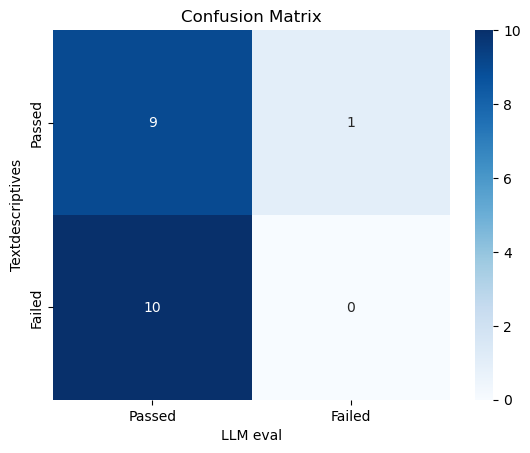

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = np.array([[TP, FP], [FN, TN]])

sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Passed", "Failed"],
            yticklabels=["Passed", "Failed"])
plt.xlabel('LLM eval')
plt.ylabel('Textdescriptives')
plt.title('Confusion Matrix')
plt.show()

In [31]:
print(nodes_failed_td_sample[0].text)

Tilpasningsprocenten er ved Finansministeriets bekendtgørelse nr. 1101 af 21. august 2023 fastsat til 1,5 for finansåret 2024.
Med lov nr. 1541 af 12. december 2023 (Et forbedret arbejdsskadesystem og lettere adgang til erstatning i forbindelse med vold på arbejdspladsen) er satser efter loven fastsat (nulstillet) pr. 1. januar 2024.
Forud for lov nr. 1541 af 12. december 2023 blev lovens satser fastsat med virkning fra 1. januar 2024 ud fra en stigning på 65,7 pct. i forhold til satserne pr. 1. januar 2003 (grundniveauet i lov om arbejdsskadesikring før vedtagelsen af lov nr. 1541 af 12. december 2023), jf. vejledning nr. 9822 af 30. oktober 2023. Godtgørelsesbeløbet for 100 pct. varigt mén for arbejdsskader indtruffet 1. juli 2002 eller senere samt overgangsbeløbet ved dødsfald blev dog fastsat ud fra en stigning på 3,5 pct. i forhold til satserne fastsat for 2023 før afrunding, jf. vejledning nr. 9822 af 30. oktober 2023.
Med lov nr.


In [32]:
print(nodes_passed_td_sample[0].text)

Vejledning om regulering af satser fra 1. januar 2024 efter lov om arbejdsskadesikring, lov om sikring mod følger af arbejdsskade, lov om arbejdsskadeforsikring og lov om forsikring mod følger af ulykkestilfælde
Indledning
Efter lov om arbejdsskadesikring, jf. lovbekendtgørelse nr. 1186 af 19. august 2022 med de ændringer, der følger af lov nr. 1541 af 12. december 2023, og lov om sikring mod følger af arbejdsskade, jf. lovbekendtgørelse nr. 943 af 16. oktober 2000, skal der med virkning fra 1. januar 2024 efter indstilling fra bestyrelsen for Arbejdsmarkedets Erhvervssikring ske regulering af lovens årslønsbeløb, godtgørelsesbeløb, overgangsbeløb samt løbende erstatninger.
Reguleringen af satserne fastsættes af Arbejdstilsynets direktør efter bemyndigelse fra beskæftigelsesministeren.
Satser efter loven reguleres med 2 procent tillagt tilpasningsprocenten for finansåret 2024 (jf. lov om en satsreguleringsprocent).


# Step 2
### Generate questions

In [17]:
from llama_index.core.prompts import PromptTemplate

# Define your custom prompt template in Danish
qa_sagsbehandler_prompt = """Nedenfor er et uddrag (kontekst) fra en længere tekst:
---------------------
{context_str}
---------------------
Givet ovenstående uddrag og ingen forudgående viden, er din opgave at generere spørgsmål til teksten.
Spørgsmålet skal indeholde specifik kontekst, således at spørgsmålet kan besvares uden tvetydighed udenfor uddraget. 
Du er en erfaren sagsbehandler, og din opgave er at stille præcis {num_questions_per_chunk} spørgsmål, som kan besvares i uddraget.
Spørgsmålene skal være af forskellig karakter og dække teksten bredt, men stilles i et sprog som en borger uden juridisk ekspertise kan forstå.
Svaret til spørgsmålet, skal kunne findes i ovenstående uddrag.

Eksempel på et spørgsmål der ikke har en specifik kontekst: 
"Hvilket dokument har den nye vejledning erstattet, og hvornår blev det tidligere dokument udsendt?", da spørgsmålet er tvetydigt og vil have flere svarmuligheder afhængigt af hvilken vejledning og dokument der refereres til.

Eksempel på et godt spørgsmål, som kan besvares uden kendskab til uddraget:
"Hvor meget vil godtgørelsen for et varigt mén være, hvis det er vurderet til 100%?"
"""

def llama_prompt_template(prompt_template: str) -> PromptTemplate:
    return PromptTemplate(prompt_template)
    
    
qa_sagsbehandler_tmlp = llama_prompt_template(qa_sagsbehandler_prompt)

In [18]:
from llama_index.finetuning import generate_qa_embedding_pairs
from llama_index.llms.openai import OpenAI

# define LLM
llm_oai = OpenAI(temperature=0.0, model="gpt-4-0125-preview")

qa_dataset = generate_qa_embedding_pairs(
    qa_generate_prompt_tmpl=qa_sagsbehandler_tmlp,
    llm=llm_oai,
    nodes=nodes_passed_td[0:10],
    num_questions_per_chunk=2,
)

100%|██████████| 10/10 [00:49<00:00,  4.92s/it]


In [33]:
qa_dataset.queries

{'8f23afcc-41a6-4e1b-b758-28da69509c4b': 'Fra hvilken dato træder de nye regler om regulering af satser i henhold til loven om arbejdsskadesikring i kraft?',
 '29a3bd9c-bc44-43ca-97ce-d7a22211299a': 'Hvem har bemyndigelsen til at fastsætte reguleringen af satserne efter loven om arbejdsskadesikring?',
 '21b49cfd-4e36-4498-b468-eb33817c9d75': 'Hvor meget udgør uddannelsesgodtgørelsen årligt, hvis man er berettiget til den i en forlænget periode efter § 18 b, stk. 3, 2. pkt.?',
 '7d7818e8-4f14-41dc-bcc3-18e3185ef7c6': 'Hvis en arbejdsskade indtræffer den 1. juli 2024 eller senere, hvilken procentdel tillægges da til erstatningen eller godtgørelsen, der svarer til grundlønnen?',
 '285e7cef-8533-4f6d-937b-c018b6c841cd': 'Hvilke typer af erstatninger og godtgørelser kan en person, der har været udsat for en arbejdsskade, eller deres efterladte, have ret til ifølge det vedlagte bilag fra Arbejdstilsynet datoen den 5. januar 2024?',
 'b63fc7a2-6136-4bea-ace5-461a748bf0f7': 'Hvordan beregnes g